# Description of Beam

In [1]:
%matplotlib inline
import scipy.io as sio
from scipy.linalg import *
from numpy import *
from math import sqrt
from time import time
from scipy.io import loadmat,savemat
from random import shuffle

In [2]:
from os import listdir
import matplotlib.pyplot as plt
from sklearn import tree
import csv
from sklearn.feature_selection import RFE

### Make full-proof version of listdir

In [3]:
def Listdir(folder):
    List = []
    for item in listdir(folder):
        if '.DS' not in item:
            List += [item]
    return List

## Loading data from .mat file  

In [4]:
constraints = sio.loadmat('constraints.mat')
stiffness = constraints['stiffness']
prop = sio.loadmat('property_data.mat')

In [5]:
volumefraction = prop['c1'][0]
print stiffness

[[  3.92265878e+00   2.37230213e+00   2.37230213e+00 ...,   1.28523268e+00
    1.28523268e+00   1.26587692e+00]
 [  2.50123117e+00   8.75728008e-01   8.75728008e-01 ...,   4.59549419e-01
    4.78905181e-01   4.78905181e-01]
 [  2.50123117e+00   1.32098896e+00   1.32098896e+00 ...,   4.78905181e-01
    4.59549419e-01   4.78905181e-01]
 ..., 
 [  3.90312782e-18   1.27000510e-02  -1.27000510e-02 ...,   2.03513966e-02
   -2.70076107e-02   3.46944695e-18]
 [  1.65257985e-03   7.57462762e-03   7.57462762e-03 ...,   1.71147161e-02
    3.12061634e-02  -3.00231196e-02]
 [  1.79280616e+00   6.92858221e-01   6.92858221e-01 ...,   3.66135567e-01
    3.51418004e-01   2.58667023e-01]]


In [6]:
pi = 3.14
L = 0.45
alphaL = 1.87510
mass = float(5)

In [7]:
a = 3
b = 20
A = a*b  # Area of the rectangle cross-section

rhop = mass/(A*L)  # Mass per unit volume

Iy = (a*pow(b,3))/12
Ix = (b*pow(a,3))/12
Ip = Ix + Iy

In [8]:
r1 = 6
r = 6.67
rat = (10-r)/(r-r1)

beta1 = 0.299;
beta2 = 0.312;
beta = (beta2+(beta1*rat))/(rat+1)
J = beta*a*pow(b,3)

### What are single crystal solutions ?

#### Mathematically, they are odfs with only one value non-zero

## Taking conjugate transpose and taking a product of stiffness with it

##### So this is a 76 dimension vector. We are trying to 

In [9]:
def getModulus(volumefraction,stiffness):
    E,G = [],[]
    odfs = []
    for i in range(len(volumefraction)):
        odf = zeros(shape=(76,1))
        odf[i] = 1/volumefraction[i]
        odfs += [odf]
        stiffness_avg = stiffness.dot(odf)
        stiffness_avg = stiffness_avg.reshape(6,6)
        S = inv(stiffness_avg)
        Ex = 1/S[0,0] 
        Gxy= 1/S[5,5]
        E +=[Ex]
        G +=[Gxy]
    return E,G,odfs
    
E,G,odfs = getModulus(volumefraction,stiffness)

## Bounds in E and G space

In [10]:
max(E), min(E), max(G), min(G)

(258.83802844021989, 85.98776910442561, 120.3116098167047, 45.476468776215064)

### So we have bounds for the E and G space given single crystal solutions


In [11]:
#w1b1 = ((alphaL^2)*sqrt((Ex*Ix)/(mass*(L^4))))/(2*pi)
def getBendingFreq(Ex):
    alphaSqr = pow(alphaL,2)
    sqrroot = sqrt((Ex*Ix)/(mass*pow(L,4)))
    w1b = (alphaSqr*sqrroot)/(2*pi)
    return w1b
    
getBendingFreq(258.83802844021989), getBendingFreq(85.987769104425624)

(133.44413554416013, 76.91371556826493)

In [12]:
#w1t = ((pi/(2*L))*sqrt((Gxy*J)/(rhop*Ip)))/(2*pi);
def getTorsionalFreq(Gxy):
    piPart = (pi/(2*L))
    sqrroot = sqrt((Gxy*J)/(rhop*Ip))
    w1t = (piPart*sqrroot)/(2*pi)
    return w1t
getTorsionalFreq(120.3116098167047),getTorsionalFreq(45.476468776215064)

(26.62247147788166, 16.367711775018922)

### Shortcuts for getBendingFreq and getTorsionalFreq functions

In [13]:
def getw1b(Ex):
    return getBendingFreq(Ex)

def getw1t(Gxy):
    return getTorsionalFreq(Gxy)

In [14]:
def getFreqForOdf(stiffness, odf):
    stiffness_avg = stiffness.dot(odf)
    stiffness_avg = stiffness_avg.reshape(6,6)
    S = inv(stiffness_avg)
    Ex = 1/S[0,0] 
    Gxy= 1/S[5,5]
    bendingFreq = getw1b(Ex)
    torsionalFreq = getw1t(Gxy)
    return bendingFreq,torsionalFreq
#     print 'Ex:',Ex
#     print 'Gxy:',Gxy
#     print 'Bending Freq:',bendingFreq
#     print 'Torsional Freq:',torsionalFreq

In [15]:
data = sio.loadmat('pinarODF.mat')
odf = []
for i in range(len(data['odf'])):
    odf += [data['odf'][i][0]]

getFreqForOdf(stiffness,odf)

(120.27137047031994, 21.49803794766861)

In [16]:
f1=loadmat('linprog_a_yield.mat')['y']
f1P = f1.conj().transpose()
odfP = sio.loadmat('pinarODF.mat')['odf']
stress = f1P.dot(odfP)[0][0]

In [17]:
stress

384.12561369108994

In [18]:
getw1b(mean(max(E)+min(E)))

154.02291048296726

In [19]:
getw1t(mean(max(G)+min(G))),getw1t(max(G)),getw1t(mean(G))

(31.251527584115237, 26.62247147788166, 21.53904764315311)

### Check for valid sample


In [20]:
def checkForValidSample(Ex,Gxy):
    w1b = getw1b(Ex)
    w1t = getw1t(Gxy)
    if w1b<120 or w1b>122.5:
        return False
    if w1t<19.5 or w1t>21.5:
        return False
    
    return True

In [21]:
Ex,Gxy = random.uniform(min(E), max(E)) ,random.uniform(min(G), max(G)) 
Ex,Gxy


(160.57330818855536, 115.50275897126551)

In [22]:
def get1000Samples():
    samples = []
    start = time()
    while len(samples)<1000:
        Ex,Gxy = random.uniform(min(E), max(E)) ,random.uniform(min(G), max(G)) 
        if checkForValidSample(Ex,Gxy):
            samples += [(Ex,Gxy)]
    
    end = time()
    print "Time elapsed:",end-start
    return samples
            

In [23]:
Data = get1000Samples()

Time elapsed: 3.14471292496


In [24]:
for i in range(1000):
    print getw1b(Data[i][0]),getw1t(Data[i][1])


120.6384909 20.1598827343
121.900731416 20.7978352183
120.242135446 19.8927748991
120.980331003 20.0597973132
120.930279103 21.4798329681
122.375094351 19.9963455767
121.409626846 21.1300691163
122.301043787 20.6044911829
121.439930157 20.1440447724
122.028172219 21.3372587069
121.203764118 20.0571215803
120.119836907 21.4417198256
120.468674669 21.347581959
120.250402157 20.1715502275
122.478631643 21.0435229009
120.096651518 21.1909951021
120.865653224 21.4430360443
121.670746522 20.2146750306
121.639497288 19.941073386
120.570015007 19.7418428329
122.239923315 21.4795583155
120.579209282 20.3116783651
120.72444366 20.3594219488
120.851461026 20.9949924115
121.224515721 20.5637111525
121.546717771 20.6702384281
120.074827264 19.504681099
121.49979253 19.8193671423
121.05347477 20.1782735144
120.550627194 19.7554977484
120.173631893 19.8196703219
121.047876025 21.1683422153
121.050947695 20.1045228149
120.765111942 19.5067570729
121.039830034 19.8506173707
120.354938916 21.4345252854


In [25]:
stress = []
odfval = []
odfs = []
for filename in Listdir('data1_upper'):
    dataList = loadmat('data1_upper/'+filename)['Data']
    for item in dataList:
        if len(item)<80:
            odfs += [item[:76]]
            odfval += [count_nonzero(item)]
            stress += [item[78]]
        else:
            odfs += [item[:76]]
            odfval += [item[76]]
            stress += [item[79]]

In [26]:
combined = zip(stress,odfs,odfval)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],odfs[:],odfval[:] = zip(*combined)


In [27]:
stress[23],getFreqForOdf(stiffness,odfs[23])

(385.22163423870768, (120.20231363561905, 21.327828037992912))

In [28]:
odfNew = array([62.5692]+[0]*75)
getFreqForOdf(stiffness,odfNew)

(92.20110778592249, 25.706406390609473)

In [30]:
nonzero(odfs[23])

(array([44, 75]),)

In [31]:
bfreq,tfreq = [],[]
print len(combined)
combinedNew = []
for i in range(len(combined)):
    bfreq,tfreq = getFreqForOdf(stiffness,odfs[i])
    if bfreq>122.5 or bfreq<120 or tfreq<19.5 or tfreq>21.5:
        pass
    else:
        combinedNew += [(stress[i],odfs[i],odfval[i])]

print len(combinedNew)
stress[:],odfs[:],odfval[:] = zip(*combinedNew)

128610
125142


In [32]:
print stress[0],getFreqForOdf(stiffness,odfs[0]),odfs[0]

385.127171324 (120.99991504136327, 21.24473759307285) [   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.           77.96977045    0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.  

In [33]:
savemat('bestSolution',mdict={'odf': odfs[0]})

In [34]:
print stress[20000],getFreqForOdf(stiffness,odfs[20000]),odfs[20000]

319.771477274 (122.01871182463812, 20.50695621125586) [   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.          111.18770899    0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.           79.75

In [35]:
savemat('terribleSolution',mdict={'odf': odfs[20000]})

In [36]:
def Plot(x,y,xLabel=None,yLabel=None,Title=None):
    plt.plot(x,y)
    if xLabel:
        plt.xlabel(xLabel)
    if yLabel:
        plt.ylabel(yLabel)
    if Title:
        plt.title(Title)

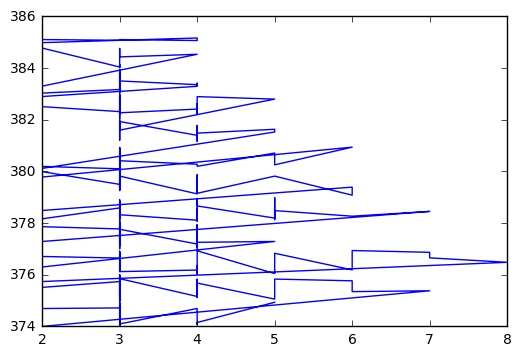

In [37]:
Plot(odfval[:1000],stress[:1000])

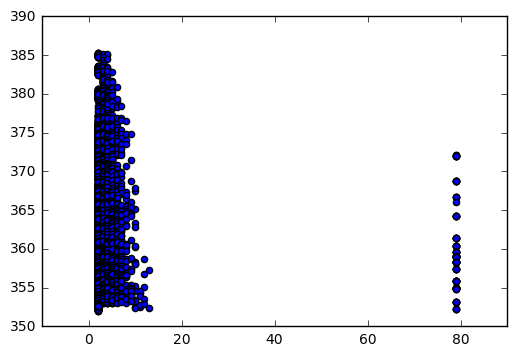

In [38]:
plt.scatter(odfval[:5000],stress[:5000])

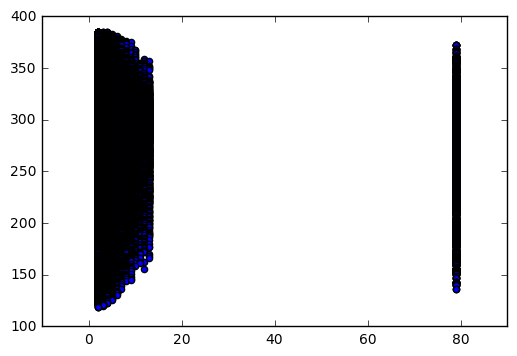

In [39]:
plt.scatter(odfval,stress)

In [40]:
stress = []
odfval = []
odfs = []
for filename in Listdir('data2_upper'):
    dataList = loadmat('data2_upper/'+filename)['Data']
    for item in dataList:
        if len(item)<80:
            odfs += [item[:76]]
            odfval += [count_nonzero(item)]
            stress += [item[78]]
        else:
            odfs += [item[:76]]
            odfval += [item[76]]
            stress += [item[79]]
combined = zip(stress,odfs,odfval)
combined = sorted(combined, key=lambda i: int(i[0]), reverse=True)
stress[:],odfs[:],odfval[:] = zip(*combined)
bfreq,tfreq = [],[]
print len(combined)
combinedNew = []
for i in range(len(combined)):
    bfreq,tfreq = getFreqForOdf(stiffness,odfs[i])
    if bfreq>114 or bfreq<100 or tfreq<21.5 or tfreq>23.5:
        pass
    else:
        combinedNew += [(stress[i],odfs[i],odfval[i])]

print len(combinedNew)
stress[:],odfs[:],odfval[:] = zip(*combinedNew)

729603
722735


In [41]:
savemat('bestSolution2',mdict={'odf': odfs[0]})
savemat('terribleSolution2',mdict={'odf': odfs[500000]})

In [42]:
stress[500000]

300.46106971605354

In [43]:
count = 0
for i in range(len(stress)):
    if stress[i]> 308.4456:
        count += 1
print count

427240


In [44]:
mean(stress),std(stress)
good = mean(stress)+std(stress)
bad = mean(stress)-std(stress)

In [45]:
print stress[0]
print getFreqForOdf(stiffness,odfs[0])
odf = {'odf':odfs[0]}
savemat('myOdf2.mat',odf)
print mean(stress)
odfLabels = []
labels = []
newStress,newOdf = [],[]
for i in range(len(stress)):
    if stress[i]<bad:
        label = '0'
    elif stress[i]>good:
        label = '1'
    else:
        continue
    odfLabel = list(odfs[i])
    odfLabel.append(label)
    labels += [label]
    odfLabels += [odfLabel]
    newStress += [stress[i]]
    newOdf += [odfs[i]]

388.090127056
(102.58983327428935, 23.481519771666083)
309.128180905


In [46]:
combined2 = zip(newStress,newOdf,labels,odfLabels)
shuffle(combined2)
newStress[:],newOdf[:],labels[:],odfLabels[:]= zip(*combined2)

In [47]:
len(newStress), max(odfLabels)

(163924,
 [40.247545439935756,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  62.298857094171723,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  '0'])

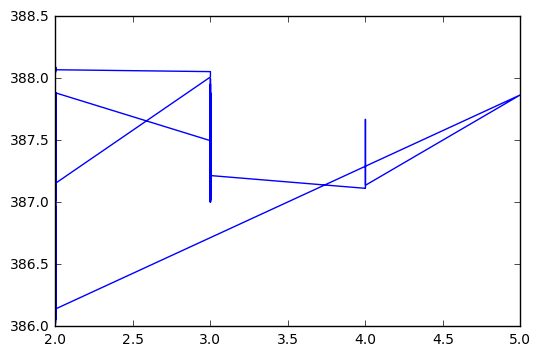

In [48]:
Plot(odfval[:1000],stress[:1000])

In [49]:
odfval[0]

2.0

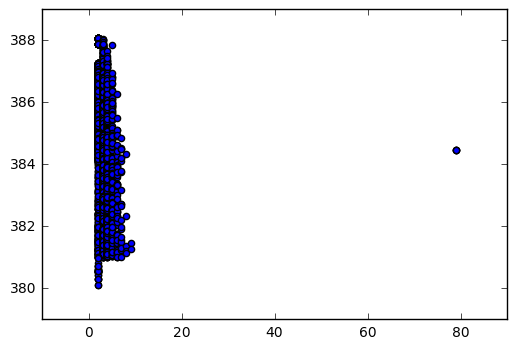

In [50]:
plt.scatter(odfval[:5000],stress[:5000])

In [51]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(newOdf[:20000],labels[:20000])